In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import numpy as np
import itertools
import math

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display, Image

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"

names = ['BI-RADS','Age','Shape','Margin','Density','Severity']

mamm_df = pd.read_csv(url, sep = ",", names = names)

mamm_df = mamm_df.replace('?', np.nan)
mamm_df = mamm_df.dropna()
mamm_df = mamm_df.reset_index(drop=True)
mamm_df = mamm_df.apply(pd.to_numeric)

print("max BI-RADS 55 is in row: ", mamm_df['BI-RADS'].idxmax())
display(mamm_df[250:260])
mamm_df = mamm_df.drop(257,axis=0)
mamm_df = mamm_df.reset_index(drop=True)
display(mamm_df[250:260])
print("BI-RADS value counts: \n",mamm_df['BI-RADS'].value_counts())

display(mamm_df.describe())

max BI-RADS 55 is in row:  257


,BI-RADS,Age,Shape,Margin,Density,Severity
250,5,54,4,5,3,1
251,5,55,4,3,3,1
252,4,64,4,4,3,0
253,5,67,4,5,3,1
254,5,75,4,3,3,1
255,5,87,4,4,3,1
256,4,46,4,4,3,1
257,55,46,4,3,3,1
258,5,61,1,1,3,1
259,4,44,1,4,3,0


,BI-RADS,Age,Shape,Margin,Density,Severity
250,5,54,4,5,3,1
251,5,55,4,3,3,1
252,4,64,4,4,3,0
253,5,67,4,5,3,1
254,5,75,4,3,3,1
255,5,87,4,4,3,1
256,4,46,4,4,3,1
257,5,61,1,1,3,1
258,4,44,1,4,3,0
259,4,32,1,1,3,0


BI-RADS value counts: 
 4    468
5    316
3     24
6      9
2      7
0      5
Name: BI-RADS, dtype: int64


,BI-RADS,Age,Shape,Margin,Density,Severity
count,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000
mean,4.332931,55.793727,2.780458,2.813028,2.915561,0.484922
std,0.688160,14.676698,1.242389,1.568107,0.351136,0.500074
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,6.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [3]:
X = mamm_df.ix[:,1:5].values
y = mamm_df.ix[:,5].values

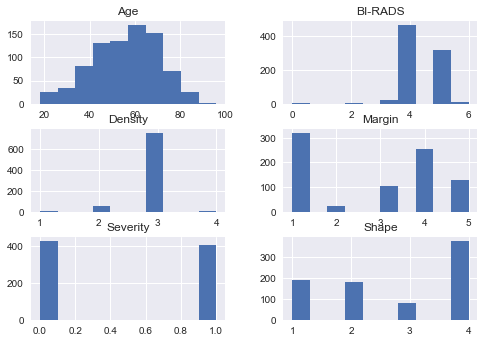

In [5]:
mamm_df.hist()
plt.show()

           BI-RADS       Age     Shape    Margin   Density  Severity
BI-RADS   1.000000  0.319146  0.407670  0.422612  0.056505  0.523483
Age       0.319146  1.000000  0.381209  0.421126  0.052626  0.456458
Shape     0.407670  0.381209  1.000000  0.738308  0.073730  0.564233
Margin    0.422612  0.421126  0.738308  1.000000  0.124831  0.574722
Density   0.056505  0.052626  0.073730  0.124831  1.000000  0.068398
Severity  0.523483  0.456458  0.564233  0.574722  0.068398  1.000000


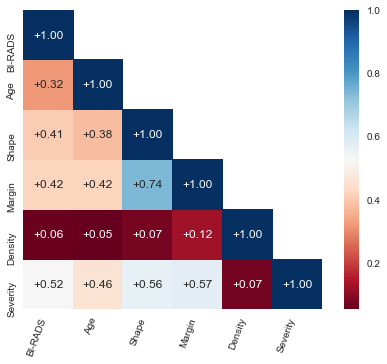

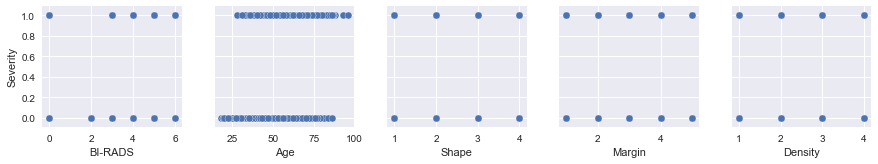

In [4]:
corr = mamm_df.corr()
print(corr)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='+.2f')
    plt.xticks(rotation=70, ha='right')

sns.pairplot(mamm_df, x_vars=['BI-RADS','Age','Shape','Margin','Density'], y_vars='Severity')

In [14]:
# decision tree model
# exclude Density and Age

X = mamm_df.drop(['Age','Density','Severity'], axis=1)
y = mamm_df.iloc[:,5]

print("X shape: ", X.shape)
print("y shape: ", y.shape)

# set up X and y as train and test data for decision tree

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

# train DecisionTreeClassifier

dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_pred = dtree_model.predict(X_test)

print(dtree_pred[:5])



X shape:  (829, 3)
y shape:  (829,)
X_train shape:  (621, 3)
y_train shape:  (621,)
[1 0 0 0 0]


In [15]:
# score accuracy

print("acc: ", accuracy_score(y_test, dtree_pred))

classification_report_nodage = classification_report(y_test, dtree_model.predict(X_test), labels=None)

print("report w/o density or age: \n", classification_report_nodage)

acc:  0.793269230769
report w/o density or age: 
              precision    recall  f1-score   support

          0       0.87      0.74      0.80       114
          1       0.73      0.86      0.79        94

avg / total       0.80      0.79      0.79       208



Confusion matrix, without normalization
[[84 30]
 [13 81]]
Normalized confusion matrix
[[ 0.74  0.26]
 [ 0.14  0.86]]


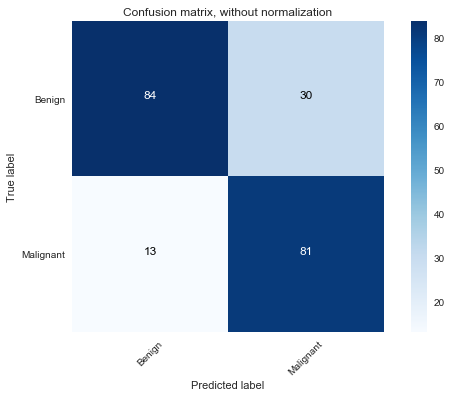

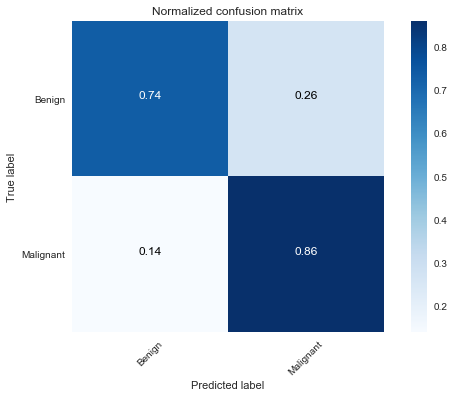

In [13]:
# create a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.rc('axes', grid = False)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, dtree_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign', 'Malignant'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign', 'Malignant'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()



Let's see how this works if we select different subsets of variables for our training data.